In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import make_regression, make_friedman1, make_blobs
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

from matplotlib.colors import ListedColormap
from tqdm import tqdm

# Let’s write an auxiliary function that will return grid for further visualization.
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

sns.set()
warnings.filterwarnings("ignore")

## Решающие деревья

Решающие деревья - один из наиболее популярных алгоритмов для решения задач классификации и регрессии. Стоит отметить, что по своей сути они относятся не только к ML, но и к реальной жизни. Например последовательная инструкция является решающим деревом. Рассмотрим фрагмент инструкции для публикаций научных сотрудников ниже.

<img align='center' src='img/hse_instr.png' width=70%><br>

В терминах ML данная инструкция решает элементарную задачу классификации - определить форму публикации по нескольким признакам:

- тип публикации
- где планируется опубликовать
и т.д.

Решающие деревья - обобщение опыта экспертов. До начала массового использования ML в бизнес-процессах задача банковского скоринга решалась людьми, которые руководствовались правилами, написанными в скоринговых картах. Данные правила можно представить в виде дерева.

В этом случае решается задача _бинарной классификации_ - о выдаче или отказе в получении кредита. Используемые признаки - _возраст, образование, доход, наличие недвижимости_.

### Дерево для задачи кредитного скоринга:
<img src='img/0_scoring.gif'>

Для построения решающего дерева можно привести следующую аналогию - игру "20 вопросов" (когда вы сидите компанией друзьей, каждому на лоб наклеен стикер с каким-то известным человеком или персонажем). Ваша задача - как можно быстрее угадать, кто у вас написан на стикере. Оптимальная стратегия - идти от общих вопросов к более узким.

Допустим, вам выпала Анджелина Джоли. Список вопросов с целью угадать ее может выглядеть так:

1. Мой человек мужского или женского пола?
2. Она живет сейчас?
3. Она политик?
4. Она знаменитость?
5. Она актриса?
6. Она снималась в боевиках?
7. У нее многодетная семья?

Стоит отметить, что в самом начале у нас самая большая неопределенность. Чтобы успешно угадать человека,
необходимо при помощи каждого последующего вопроса эту неопределенность снижать. И желательно это делать так,
чтобы на каждом шаге эта неопределенность снижалась наибольшим образом. Если вернуться к примеру, то первым вопросом
мы сразу отсекли примерно половину известных людей, вторым - еще больше и т.д.

Но информативность выборки можно также выразить не только какими-то интуитивными соображениями, но и в виде какой-то количественной характеристики, про которые речь пойдет ниже.

## Критерии информативности


### Индекс Джини

Индекс Джини (Gini impurity) - мера того, насколько рандомно выбранный элемент в выборке будет неверно классифицирован согласно распределению меток в нашей выборке. 

Допустим у нас есть *J* классов, $i \in \{1,2,\dots,J\}$, с соответствующими вероятностями $p_i \in \{p_1,\dots,p_J\}$

Тогда индекс Джини для выборки X запишется следующим образом:

$$Gini(X) = \sum^J_{i=1}p_i\sum_{k \neq i} p_k = \sum^J_{i=1}p_i(1 - p_i)$$

$$Gini(X) = \sum^J_{i=1}p_i - \sum^J_{i=1}p_i^2 = 1 - \sum^J_{i=1}p_i^2$$

Gini принимает значения от 0 до 1. 1 - максимальная неопределенность, 0 - минимальная.

Рассмотрим конкретный пример:

1) В выборке только объекты одного типа.

$X = [1, 1, 1, 1]$. Тогда $p_i = 1 \rightarrow Gini(X) = 1 - 1 = 0$

2) В выборке объекты двух типов в одинаковых пропорциях

$X = [1, 1, 0, 0]$, $p_1 = 0.5$, $p_2 = 0.5 \rightarrow Gini(X) = 1 - 0.25 - 0.25 = 0.5$

Аналогично для большего количества. Основная мысль - чем больше разных объектов в выборке, тем Gini больше, чем меньше - тем соответственно Gini меньше

### Shannon entropy

Рассмотрим дискретную случайную величину,
принимающую $K$ значений с вероятностями $p_1, \dots, p_K$
соответственно.
**Энтропия** этой случайной величины определяется как:
$$H(p) = -\sum_{k = 1}^{K} p_k \log_2 p_k$$

Энтропию Шэннона следует воспринимать как меру хаоса системы. Аналогично индексу Джини, чем больше разнообразных объектов в нашей системе (или выборке), тем больше энтропия.

Несколько примеров:

1) $X = [1, 1, 1, 1]$, $p_1 = 1 \rightarrow H(X) = -log_2(1) = 0$

2) $X = [1, 1, 0, 0]$, $p_1 = 0.5$, $p_2 = 0.5 \rightarrow H(X) = -log_2(2^{-1})  = 1$

Имея количественный критерий информативности, мы можем разбивать исходную выборку на несколько частей.
Будем считать разбиение наилучшим, если прирост информации после разбиения будет наибольшим среди всех остальных разбиений.

### Information Gain

$$IG(Q) = H_0 - \sum\limits_{i=1}^q \frac{N_i}{N} H_i $$

$H_0$ - значение критерия информативности перед разбиением

$H_i$, $i \in \{1,\dots,q\}$ - значения критерия информативности на каждой подвыборке, полученной при разбиении исходной на $q$ частей

$N_i$ - количество элементов в $i$-ой подвыборке, $N$ - количество элементов в исходной выборке

Т.е. Information Gain - исходное значение критерия перед разбиением минус средневзвешенное значений критерия на подвыборках после разбиения.

# Построение деревьев

Рассмотрим следующий алгоритм

1. Создать узел t.
2. Если в узле находятся объекты одного класса или же достигнут критерий остановки - останавливаемся и присваиваем предиктивную модель (как выбирать класс, попав в соотв. узел) узлу t.
3. Среди всех признаков, среди всех значений признаков для выборки X - найти наилучший сплит
   $L = L_{left} + L_{right}$, дающий наибольший **Information Gain**
4. Повторить п. 1 для $L_{left}$ и $L_{right}$

На конкретном примере:

### Предсказание цвета шарика по его координате
<img src='img/0_entropy_statement.png' Width=1200>

* Вероятности вытаскивания синего и жёлтого шариков соответственно: $$ p_1 = \frac{9}{20}, p_2 = \frac{11}{20}$$
* Энтропия такого состояния: $$ S_0 = -\frac{9}{20} log_2 \frac{9}{20} - \frac{11}{20} log_2 \frac{11}{20} \approx 1$$

Как изменится энтропия, если разбить шарики на две группы?
<img src='img/0_entropy_first_split.png' Width=1200>

* Для первой группы: $$ S_1 = -\frac{8}{13} log_2 \frac{8}{13} - \frac{5}{13} log_2 \frac{5}{13} \approx 0,96 $$

* И для второй: $$ S_2 = -\frac{6}{7} log_2 \frac{6}{7} - \frac{1}{7} log_2 \frac{1}{7} \approx 0,6 $$

* Энтропия уменьшилась в обеих группах. 
* Мера прироста информации:
* $$IG(x\leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16$$

<img src='img/0_entropy_split.png' Width=800>

* Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0 ($log_2 ⁡1=0$), что соответствует представлению, что группа шариков одного цвета – упорядоченная.

Наш алгоритм является жадным, поэтому он имеет свойство переусложнять структуру дерева, см. пример ниже.

<img src='img/0_greedy_tree.png' Width=900>

## Работа с численными признаками

In [2]:
data = pd.DataFrame({'Age': [17,64,18,20,38,49,55,25,29,31,33],
                     'Loan Default': [1,0,1,0,1,0,0,1,1,0,1]})
data

,Age,Loan Default
0,17,1
1,64,0
2,18,1
3,20,0
4,38,1
5,49,0
6,55,0
7,25,1
8,29,1
9,31,0


Допустим у нас есть численный признак, который необходимо использовать при построении дерева.
По каким значениям этого признака дерево будет делать сплиты (с учетом того, что значений может быть бесконечно много)?

Дерево:
- Отсортирует данный признак по значению

In [3]:
data.sort_values(by=['Age'])

,Age,Loan Default
0,17,1
2,18,1
3,20,0
7,25,1
8,29,1
9,31,0
10,33,1
4,38,1
5,49,0
6,55,0


В данной ситуации дерево не будет рассматривать все возможные значения в интервале от наименьшего до наибольшего с каким-то шагом. Вместо этого будут рассмотрены те значения отсортированные по возрасту, при которых таргет меняется с 1 и на 0, и в качестве split значения будет взято среднее.

Например:

1. Age 18 - 1, Age 20 - 0 $\rightarrow split \space value = 19$
2. Age 38 - 1, Age 49 - 0 $\rightarrow split \space value = 43.5$

И т.д.

## Критерии в задачах регрессии
В задачах регрессии, как правило, в качестве критерия выбирают дисперсию ответов в листе:
$$
H_R(R_m) = \frac{1}{N_m} \sum_{(x_i,\,y_i) \in R_m} \left(y_i-\frac{1}{N_m}\sum_{(x_i,\,y_i) \in R_m} y_j \right)^2.
$$
Можно использовать и другие критерии - например, среднее абсолютное отклонение от медианы.

Пример:

In [38]:
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

Визуализируем полученные результаты:

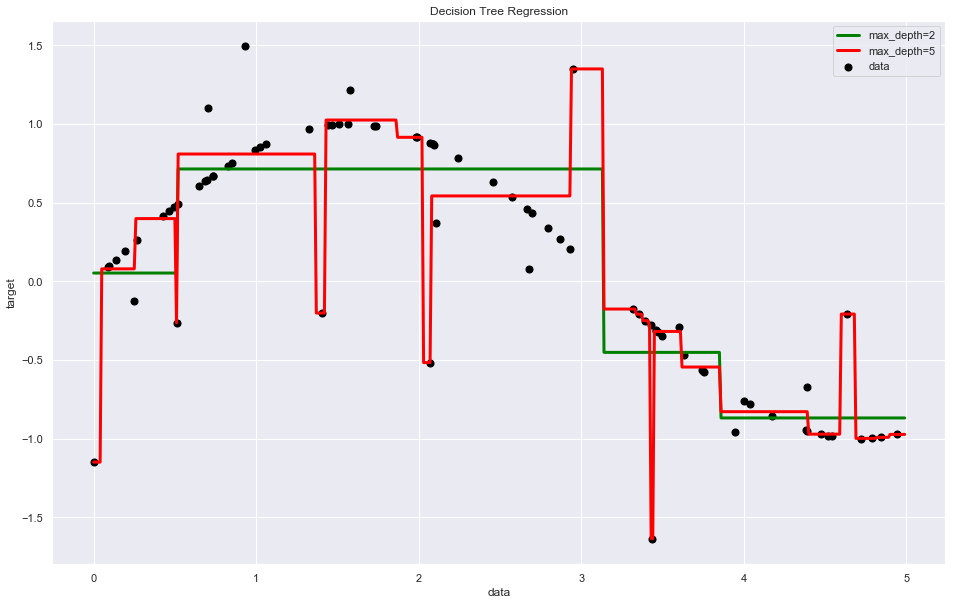

In [39]:
plt.figure(figsize=(16, 10))

plt.scatter(X, y, s=50, color="black", label="data")
plt.plot(X_test, y_1, color="green", label="max_depth=2", linewidth=3)
plt.plot(X_test, y_2, color="red", label="max_depth=5", linewidth=3)

plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

# Критерий останова построения дерева

Для любой непротиворечивой обучающей выборки можно построить решающее дерево, которое имеет нулевую ошибку на данной выборке. Если мы рассмотрим объекты, как точки в пространстве признаков, то каждую эту точку можно ограничить n-мерным кубиком, который не будет содержать других точек. n-мерный кубик прекрасно можно задать деревом.

Однако в этом случае имеет место **переобучение**. 

В связи с этим встаёт вопрос: в каком случае вершину следует объявить листовой?

Рассмотрим модельную задачу регрессии. Объектами будут являться точки на плоскости (т.е. каждый объект описывается 2 признаками), целевой переменной — расстояние от объекта до точки (0, 0).

Сгенерируем данные

In [4]:
data_x = np.random.normal(size=(100, 2))
data_y = (data_x[:, 0] ** 2 + data_x[:, 1] ** 2) ** 0.5

Визуализируем их

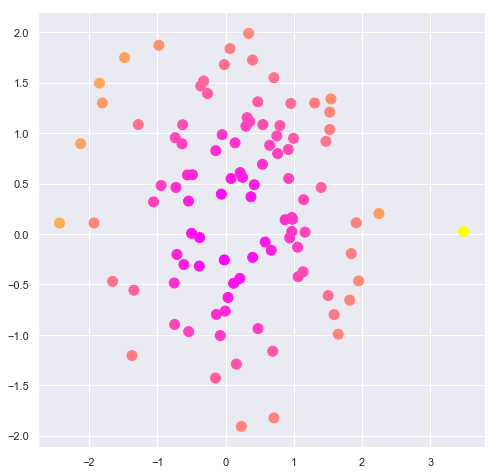

In [5]:
plt.figure(figsize=(8, 8))
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring')
plt.show()

Обучим регрессор

In [6]:
clf = DecisionTreeRegressor()
clf.fit(data_x, data_y)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

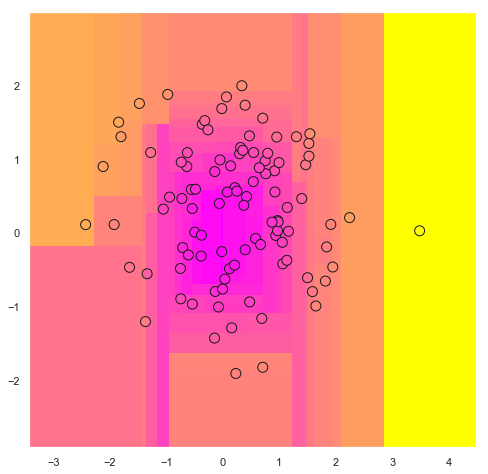

In [7]:
xx, yy = get_grid(data_x)

predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(8, 8))
plt.pcolormesh(xx, yy, predicted, cmap='spring')
plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=100, cmap='spring', edgecolor='k')

Посмотрим как будет выглядить разделение плоскости в зависимости от 
- минимального количества объектов в листе
- максимальной глубины дерева

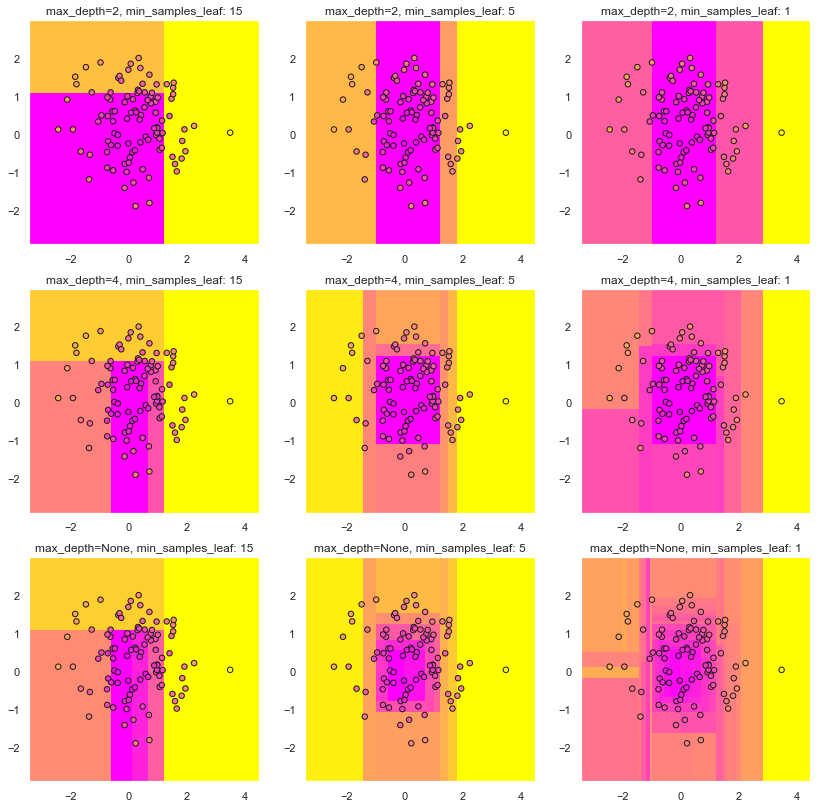

In [8]:
plt.figure(figsize=(14, 14))

for i, max_depth in enumerate([2, 4, None]):
    for j, min_samples_leaf in enumerate([15, 5, 1]):
        
        clf = DecisionTreeRegressor(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
        clf.fit(data_x, data_y)
        
        xx, yy = get_grid(data_x)
        predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        
        plt.subplot2grid((3, 3), (i, j))
        plt.pcolormesh(xx, yy, predicted, cmap='spring')
        plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='spring', edgecolor='k')
        plt.title('max_depth=' + str(max_depth) + ', min_samples_leaf: ' + str(min_samples_leaf))

- Увеличение максимальной глубины и/или уменьшение минимального количества объектов выборки в листе приводит к увеличению качества на обучающей выборке и переобучению.

### Решающие деревья vs линейные модели

### Линейная зависимость

In [41]:
X_data, y_data = make_regression(n_samples=2000, noise=100, n_features=10)

Посмотрим на то, как меняется качество в зависимости от глубины дерева

In [42]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=1), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-36383.53019475323

In [43]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=5), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-26387.11526126358

In [44]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-30362.39962094659

100%|██████████| 39/39 [00:02<00:00, 16.65it/s]


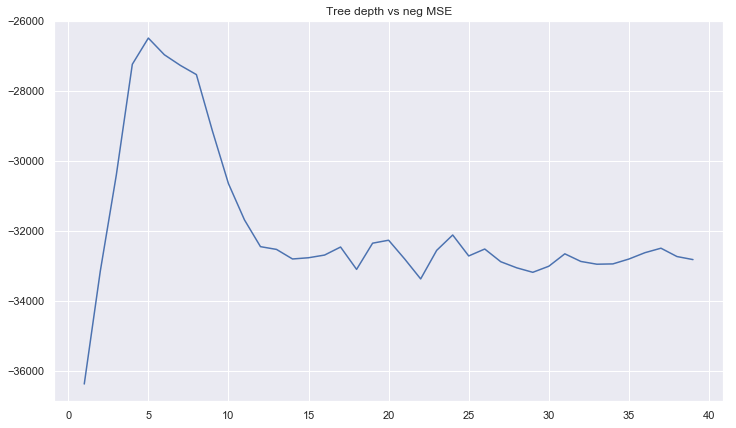

In [45]:
from tqdm import tqdm

depth_values = range(1, 40, 1)
cv_results = []

for depth_value in tqdm(depth_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(max_depth=depth_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Tree depth vs neg MSE")
plt.plot(depth_values, cv_results)
plt.show()

Теперь проделаем тоже самое для минимального количества примеров в листе

In [47]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=2), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-31858.387157272373

In [48]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=5), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-27753.303101622703

In [49]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-25278.44202455747

100%|██████████| 10/10 [00:00<00:00, 23.03it/s]


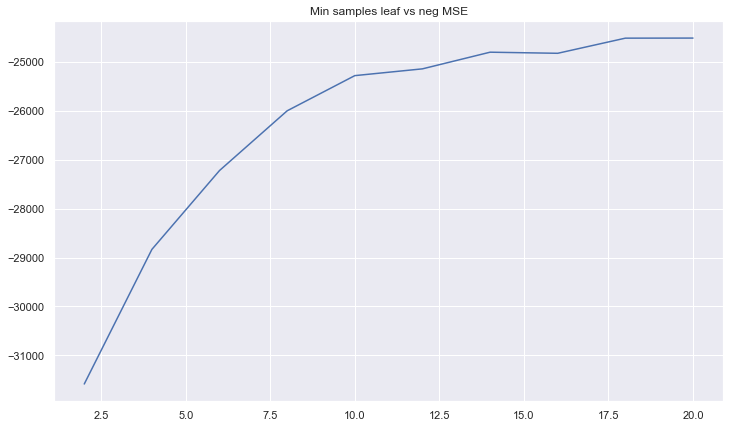

In [50]:
leaf_values = range(2, 21, 2)
cv_results = []

for leaf_value in tqdm(leaf_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(min_samples_leaf=leaf_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Min samples leaf vs neg MSE")
plt.plot(leaf_values, cv_results)
plt.show()

In [51]:
%%time
gs = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid ={
        'criterion': ['mse', 'mae'],
        'max_depth': range(1, 21, 3),
        'min_samples_leaf': range(1, 21, 3),
    },
    scoring='neg_mean_squared_error'
)
gs.fit(X_data, y_data)

print(gs.best_params_)
print(gs.best_score_)

{'criterion': 'mse', 'max_depth': 10, 'min_samples_leaf': 13}
-24110.18950825563
CPU times: user 16 s, sys: 42.4 ms, total: 16 s
Wall time: 16.1 s


Теперь сравним с обычной линейной регрессией

In [53]:
np.mean(cross_val_score(
    LinearRegression(), X_data, y_data, cv=5, scoring='neg_mean_squared_error'
))

-10609.57116975872

### Вывод

При соблюдении линейной зависимости между признаками и таргетом линейные модели проявляют себя лучше, нежели чем Decision Trees (внезапно)

### Нелинейная зависимость между признаками и таргетом

In [54]:
X_data, y_data = make_friedman1(n_samples=1000, noise=10, n_features=10)

Аналогично меняем глубину дерева

In [55]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=1), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-114.30948624878582

In [56]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=5), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-124.37580887711724

In [23]:
np.mean(cross_val_score(
    DecisionTreeRegressor(max_depth=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-192.99575046405076

100%|██████████| 20/20 [00:00<00:00, 32.75it/s]


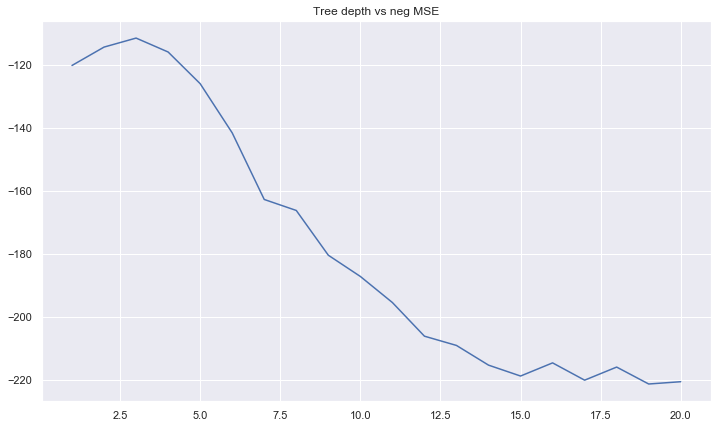

In [24]:
depth_values = range(1, 21, 1)
cv_results = []

for depth_value in tqdm(depth_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(max_depth=depth_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Tree depth vs neg MSE")
plt.plot(depth_values, cv_results)
plt.show()

Меняем минимальное количество примеров в листе

In [57]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=2), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-210.18056334478942

In [58]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=10), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-140.38816051291283

In [59]:
np.mean(cross_val_score(
    DecisionTreeRegressor(min_samples_leaf=20), 
    X_data, y_data, 
    cv=5, scoring='neg_mean_squared_error',
))

-123.77736830877352

100%|██████████| 19/19 [00:00<00:00, 53.91it/s]


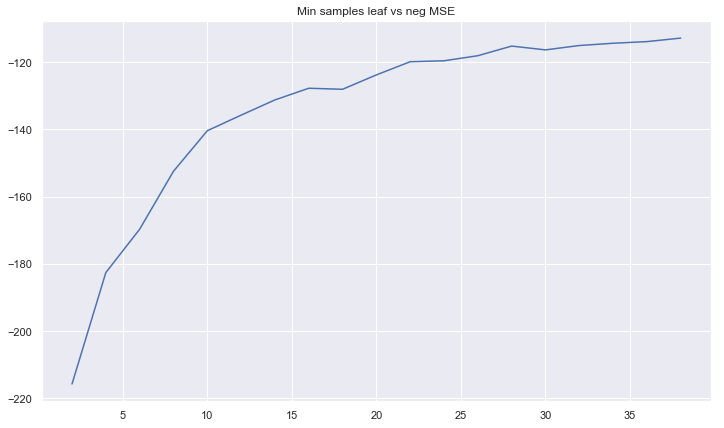

In [60]:
leaf_values = range(2, 40, 2)
cv_results = []

for leaf_value in tqdm(leaf_values):
    avg_score = np.mean(cross_val_score(
        DecisionTreeRegressor(min_samples_leaf=leaf_value), 
        X_data, y_data, 
        cv=5, scoring='neg_mean_squared_error',
    ))
    cv_results.append(avg_score)
    
plt.figure(figsize=(12,7))
plt.title("Min samples leaf vs neg MSE")
plt.plot(leaf_values, cv_results)
plt.show()

Подберем теперь оптимальные параметры

In [29]:
%%time
gs = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid ={
        'criterion': ['mse', 'mae'],
        'max_depth': range(1, 21, 3),
        'min_samples_leaf': range(1, 21, 3),
    },
    scoring='neg_mean_squared_error'
)
gs.fit(X_data, y_data)

print(gs.best_params_)
print(gs.best_score_)

{'criterion': 'mse', 'max_depth': 4, 'min_samples_leaf': 16}
-113.075862164238
CPU times: user 5.34 s, sys: 54.9 ms, total: 5.39 s
Wall time: 5.41 s


Сравним полученные результаты с линейной регрессией

In [61]:
np.mean(cross_val_score(
    LinearRegression(), X_data, y_data, cv=5, scoring='neg_mean_squared_error'
))

-103.32972667223198

### Вывод

При нелинейной зависимости между таргетом и признаками Linear Regression сравнима с Decision Trees

## Деревья vs линейные классификаторы

In [62]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from matplotlib.colors import ListedColormap

RANDOM_SEED = 42
CLUSTER_STD = 4

blobs = make_blobs(centers=2, cluster_std=CLUSTER_STD, random_state=RANDOM_SEED)
X_train, X_test, y_train, y_test = train_test_split(blobs[0], blobs[1], test_size=0.3, random_state=RANDOM_SEED)

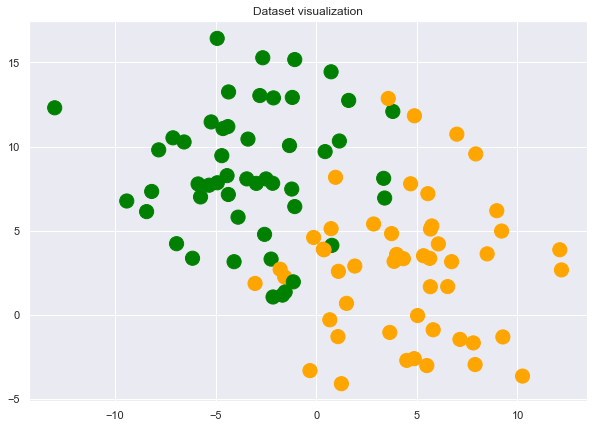

In [63]:
colors = ListedColormap(["green", "orange"])

plt.figure(figsize=(10,7))
plt.title("Dataset visualization")
plt.scatter(blobs[0][:,0], blobs[0][:,1], c=blobs[1], cmap=colors, s=200)
plt.show()

In [64]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

tree_model = DecisionTreeClassifier(max_depth=4)
tree_model.fit(X_train, y_train)

logreg_preds = logreg_model.predict(X_test)
tree_preds = tree_model.predict(X_test)

logreg_score = accuracy_score(y_test, logreg_preds)
tree_score = accuracy_score(y_test, tree_preds)

print(f"Logreg acc - {logreg_score}, DT acc - {tree_score}")

weights = np.append(logreg_model.intercept_, logreg_model.coef_)
x1 = np.linspace(-4, 4, 100)
x2 = - weights[0] / weights[2] - weights[1] / weights[2] * x1

Logreg acc - 0.9333333333333333, DT acc - 0.8333333333333334


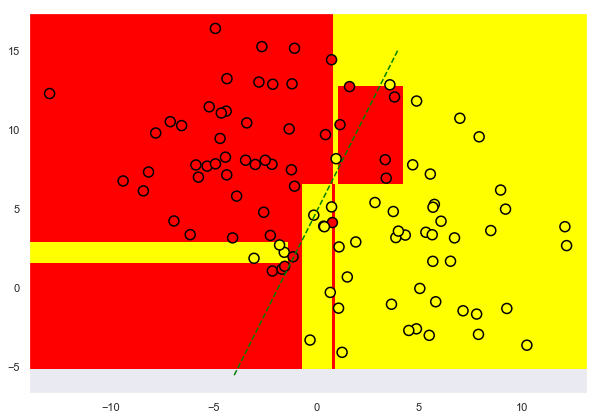

In [66]:
clf_tree = DecisionTreeClassifier(criterion='entropy', max_depth=500, 
                                  random_state=17)


# training the tree
clf_tree.fit(blobs[0], blobs[1])

# some code to depict separating surface
xx, yy = get_grid(blobs[0])
predicted = clf_tree.predict(np.c_[xx.ravel(), 
                                   yy.ravel()]).reshape(xx.shape)

plt.figure(figsize=(10,7))
plt.pcolormesh(xx, yy, predicted, cmap='autumn')
plt.plot(x1, x2, linestyle="--", color="green", label="hyperplane")
plt.scatter(blobs[0][:, 0], blobs[0][:, 1], c=blobs[1], s=100, 
            cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

### Вывод

При линейно разделимой выборке деревья - фиаско

### Обобщим вышесказанное

**Преимущества**

- хорошо интерпретируются
- легко обобщаются для регрессии и классификации
- допускаются разнотипные данные

**Недостатки**

- Сравнение с линейными алгоритмами на линейно разделимой выборке - фиаско
- Переобучение
- Неустойчивость к шуму, составу выборки, критерию

**Способы устранения недостатков**

- прунинг (усечение) - применяется в основном в банковском скоринге (требование со стороны ЦБ к интерпретируемости модели)
- композиции (леса) деревьев

**Pruning**

<img src='img/pruning.png' Width=800>

### Неустойчивость решающих деревьев

Решающие деревья — это алгоритмы, неустойчивые к изменениям обучающей выборки, т.е. при малейших её изменениях итоговый классификатор может радикально измениться. Посмотрим, как будет меняться структура дерева при обучении на разных 90%-х подвыборках.

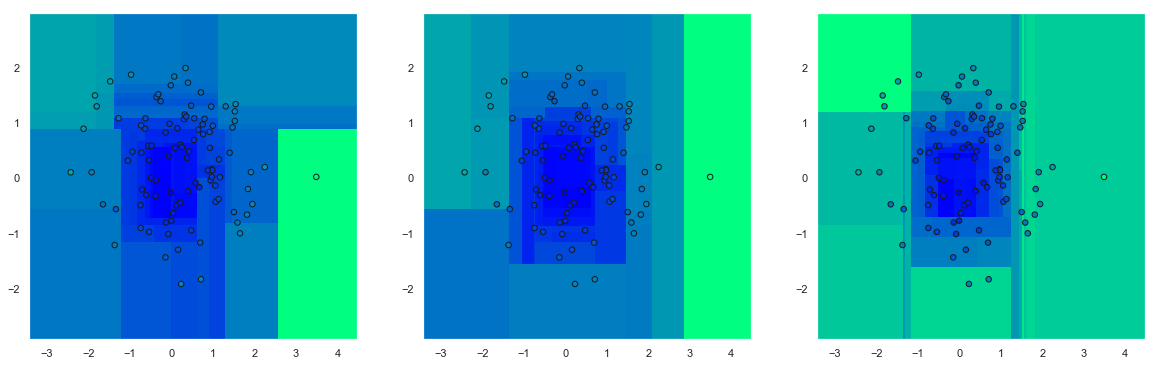

In [67]:
plt.figure(figsize=(20, 6))

for i in range(3):
    clf = DecisionTreeRegressor(random_state=42)

    indecies = np.random.randint(data_x.shape[0], size=int(data_x.shape[0] * 0.9))
    clf.fit(data_x[indecies], data_y[indecies])
    
    xx, yy = get_grid(data_x)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='winter')
    plt.scatter(data_x[:, 0], data_x[:, 1], c=data_y, s=30, cmap='winter', edgecolor='k')

In [69]:
from sklearn.model_selection import KFold

folds = KFold(5)
list(folds.split(data_x, data_x))

[(array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
         71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
         88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
  array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
         17, 18, 19, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53,
         54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70,
         71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87,
         88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]),
  array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36,
         37, 38, 39])),
 (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13,

In [70]:
list(folds.split(data_x[:10], data_x[:10]))

[(array([2, 3, 4, 5, 6, 7, 8, 9]), array([0, 1])),
 (array([0, 1, 4, 5, 6, 7, 8, 9]), array([2, 3])),
 (array([0, 1, 2, 3, 6, 7, 8, 9]), array([4, 5])),
 (array([0, 1, 2, 3, 4, 5, 8, 9]), array([6, 7])),
 (array([0, 1, 2, 3, 4, 5, 6, 7]), array([8, 9]))]